In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

import pandas as pd
import numpy as np
import nltk

import tensorflow as tf
import re
import random
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, models, callbacks, optimizers

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

In [122]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [123]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_train, X_val, y_train, y_val = train_test_split(
    train['text'], train['target'], test_size=0.2, random_state=SEED
)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [125]:
VOCAB_SIZE = 50000
OOV_TOKEN = "<UNK>"
MAX_LEN = 50

clean_texts_train = X_train.map(clean_text)
clean_texts_val = X_val.map(clean_text)
clean_texts_test = test['text'].map(clean_text)

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(clean_texts_train)

def texts_to_padded(x):
    seqs = tokenizer.texts_to_sequences(x)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

Xtr = texts_to_padded(clean_texts_train)
Xva = texts_to_padded(clean_texts_val)
Xte = texts_to_padded(clean_texts_test)

word_index = tokenizer.word_index
vocab_len = min(VOCAB_SIZE, len(word_index) + 1)



In [126]:
train_tokens = [t.split() for t in X_train]

W2V_DIM = 200
w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=W2V_DIM,
    window=5,
    min_count=2,
    workers=4,
    seed=SEED,
    sg=1
)

# Build embedding matrix aligned with Keras tokenizer indices
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_len, W2V_DIM)).astype(np.float32)
for word, idx in word_index.items():
    if idx >= vocab_len:
        continue
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]

In [127]:
model = models.Sequential([ #["hola", "como", "estas", "?"]
    layers.Embedding(#["hola", "como", "estas", "?"] -> #[[...], [...], [...], [...]]
        input_dim=vocab_len,
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=True,
        mask_zero=False
    ),

    layers.SpatialDropout1D(0.3),

    layers.Conv1D(filters=64, kernel_size=5, padding="same", activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.Bidirectional(layers.GRU(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(1, activation="sigmoid"),
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy",
                  metrics=["accuracy"])
model.build(input_shape=(None,50))

early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

In [128]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 50, 200)        │     2,727,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ (None, 50, 200)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 50, 64)         │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 25, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │        37,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,839,033 (10.83 MB)

 Trainable params: 2,839,033 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
hist = model.fit(Xtr,y_train, epochs=30, validation_data=(Xva, y_val), callbacks=[early_stopper])

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5414 - loss: 0.6899 - val_accuracy: 0.5739 - val_loss: 0.6779
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5726 - loss: 0.6805 - val_accuracy: 0.5739 - val_loss: 0.6700
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5908 - loss: 0.6709 - val_accuracy: 0.5962 - val_loss: 0.6523
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6384 - loss: 0.6414 - val_accuracy: 0.6861 - val_loss: 0.6058
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6851 - loss: 0.5966 - val_accuracy: 0.7380 - val_loss: 0.5620
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7177 - loss: 0.5576 - val_accuracy: 0.7459 - val_loss: 0.5358
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7539 - loss: 0.5189 - val_accuracy: 0.7551 - val_loss: 0.5205
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7711 - loss: 0.4962 - val_acc

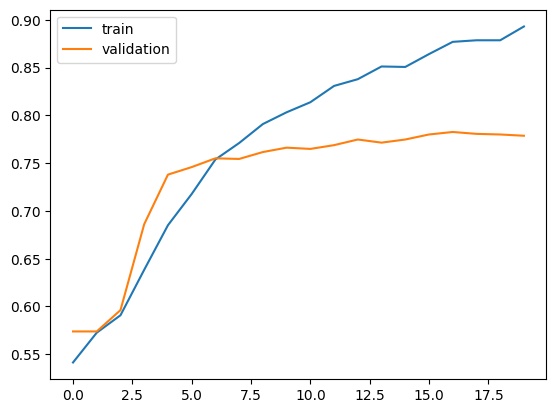

In [130]:
acc = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
plt.plot(acc, label='train')
plt.plot(acc_val, label='validation')
plt.legend()
plt.show()

In [133]:
y_pred = (model.predict(Xva) > 0.5).astype(int)
f1 = f1_score(y_val, y_pred)
print("F1 Score:", f1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1 Score: 0.6890299184043518


In [132]:
y_pred_test = (model.predict(Xte) > 0.5).astype(int)
submission = pd.DataFrame({
    'id': test['id'],
    'target': y_pred_test.flatten()
})
submission.to_csv('submission/neural_network_v1_submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
